In [63]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scrublet as scr
import scipy.io
import sys
import scanpy.api as sc

sc.settings.verbosity = 3
sc.logging.print_versions()
results_file = '/Users/samuelmorabito/Documents/kessenbrock_rotation/data/ind4.h5ad'
sc.settings.set_figure_params(dpi=200)

scanpy==1.3.2 anndata==0.6.10 numpy==1.15.3 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [48]:
#load data:
data_dir = "/Users/samuelmorabito/Documents/kessenbrock_rotation/Doublet_Pipelines_Data/ind4/GRCh38/"
counts_matrix = scipy.io.mmread(data_dir + '/matrix.mtx').T.tocsc()
barcodes = np.array([line[:-1] for line in open(data_dir + '/barcodes.tsv')])

In [3]:
doublet_rate = 0.06
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=doublet_rate)

In [4]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2,
                                                         min_cells=3,
                                                         min_gene_variability_pctl=85,
                                                         n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 3.1%
Estimated detectable doublet fraction = 47.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.5%
Elapsed time: 6.4 seconds


In [5]:
scrub.set_embedding('tSNE', scr.get_tsne(scrub.manifold_obs_, angle=0.9))

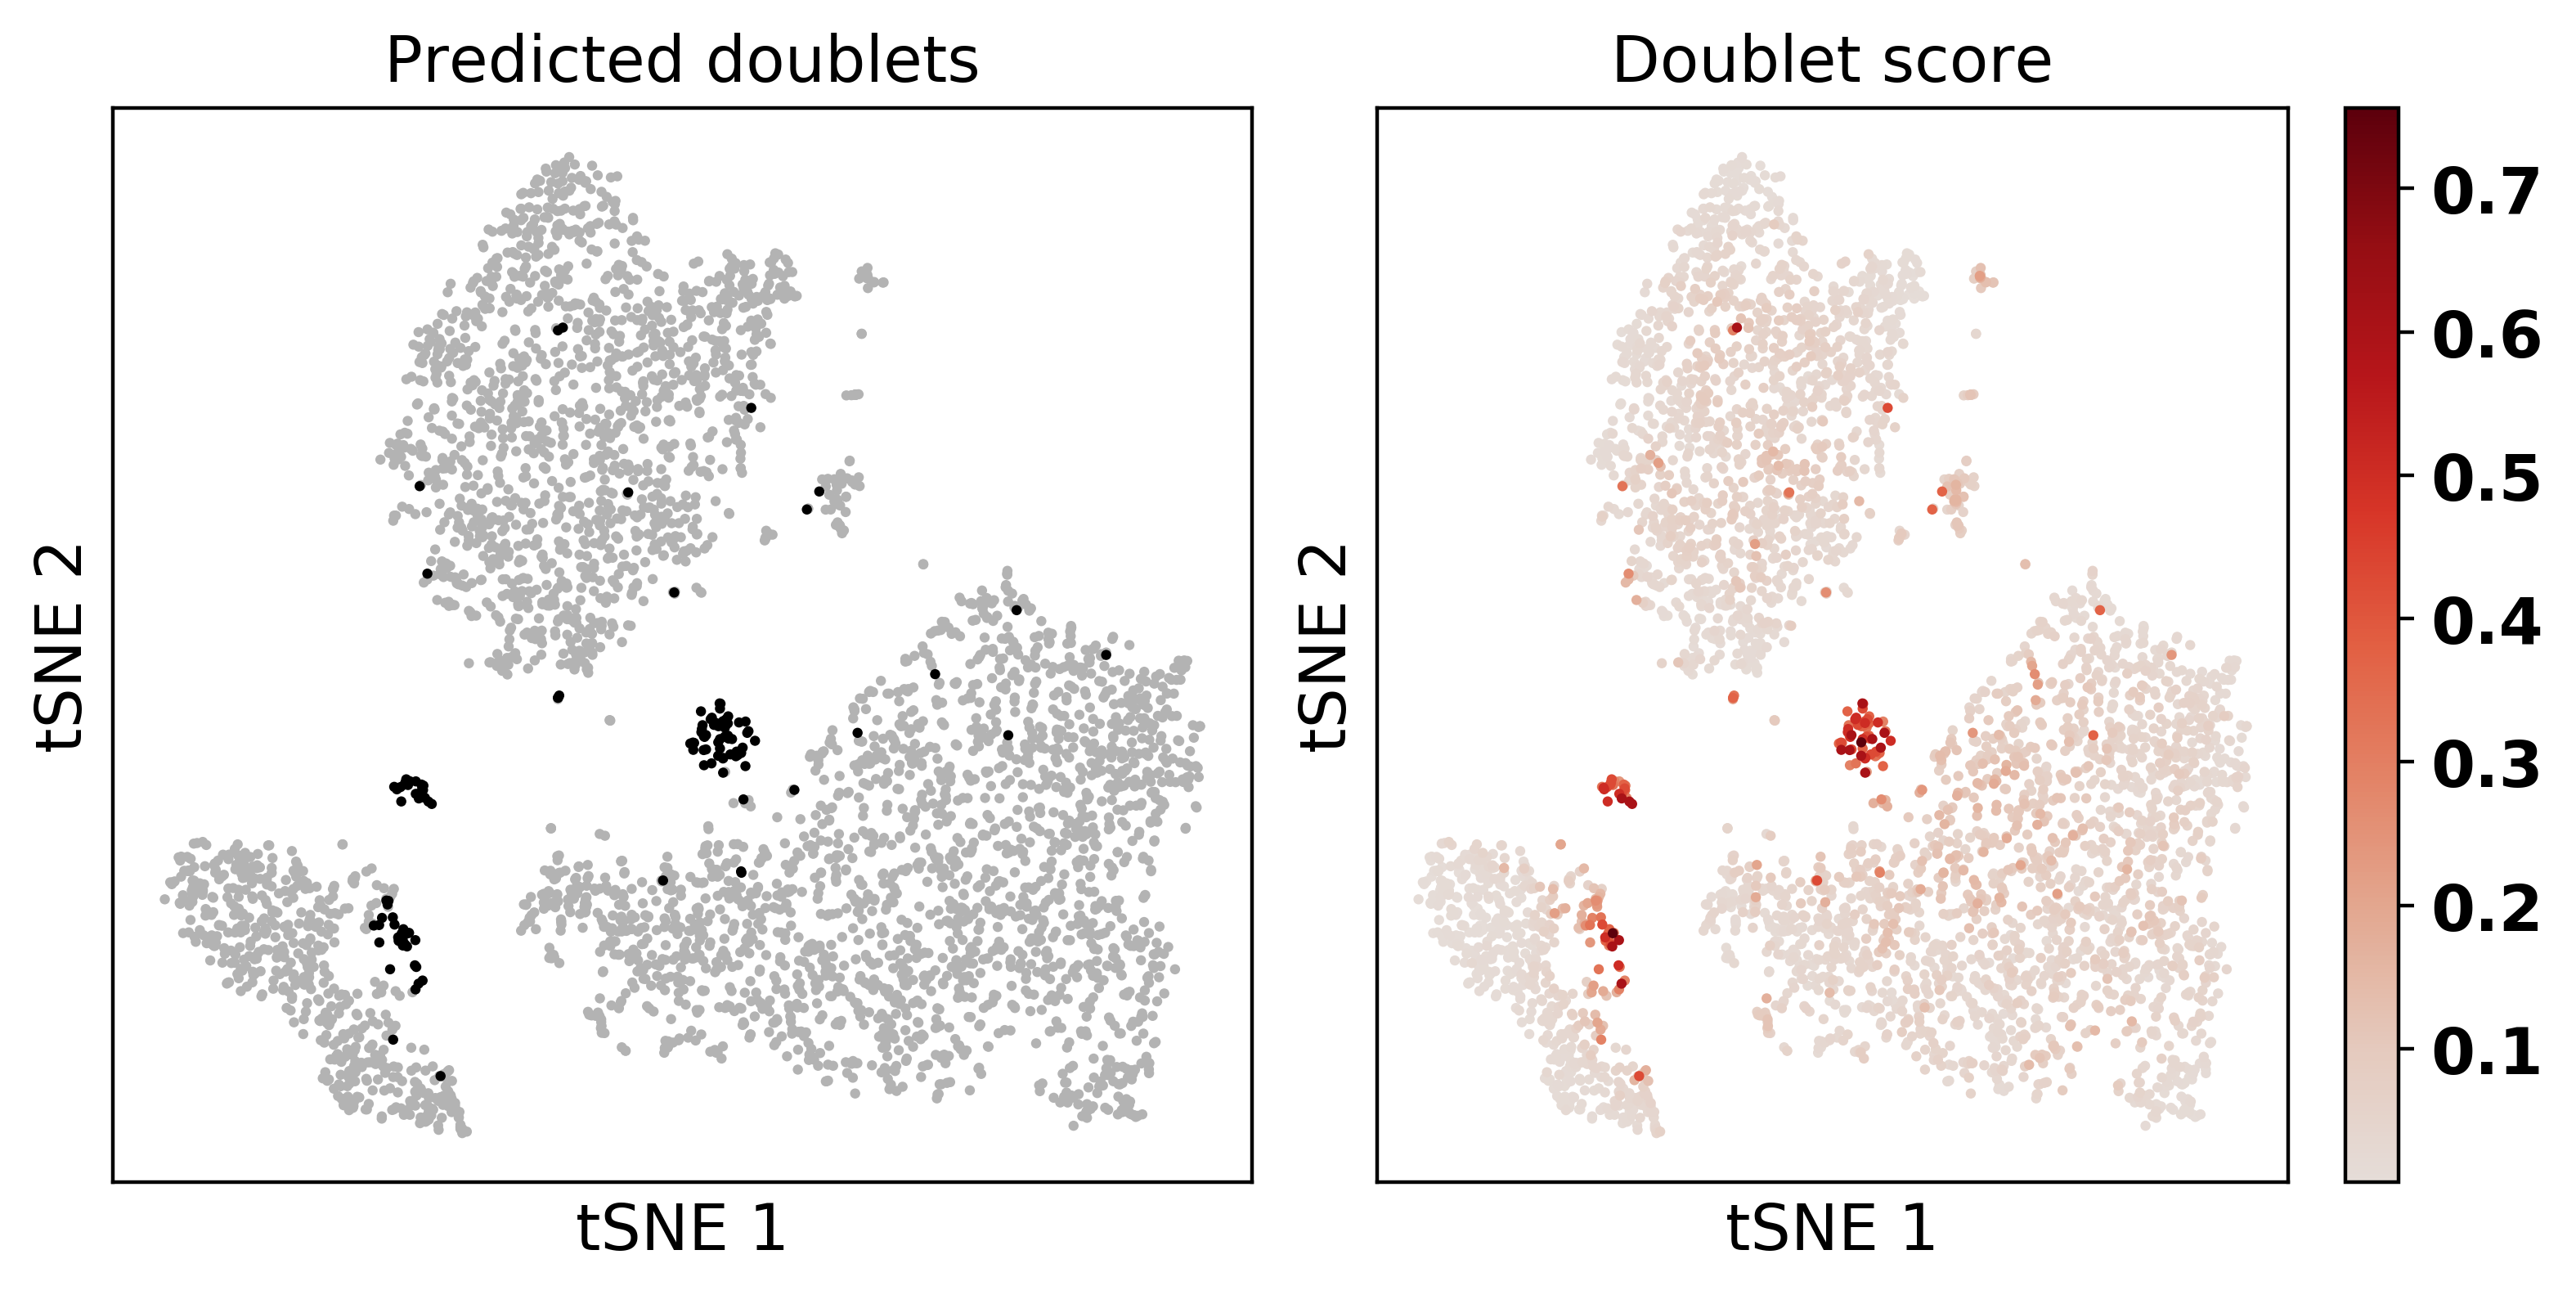

In [77]:
f = scrub.plot_embedding('tSNE', order_points=True)

In [9]:
? scrub.plot_embedding()

In [104]:
a = f[0].axes

In [106]:
type(a[1])

matplotlib.axes._subplots.AxesSubplot

In [107]:
? matplotlib.axes._subplots.AxesSubplot


Object `matplotlib.axes._subplots.AxesSubplot` not found.


In [13]:
ind4 = sc.read_10x_mtx(
    "/Users/samuelmorabito/Documents/kessenbrock_rotation/Doublet_Pipelines_Data/ind4/GRCh38/",
    var_names = 'gene_symbols',
    cache=True
)

In [17]:
#filter out cells with less than 500 genes, filter out genes with less than 3 cells:
sc.pp.filter_cells(ind4, min_genes=500)
sc.pp.filter_genes(ind4, min_cells=3)

In [25]:
mito_genes = [name for name in ind4.var_names if name.startswith("MT-")]

#compute fraction of counts in mito genes vs all genes for each cell:
ind4.obs['percent_mito'] = np.sum(ind4[:, mito_genes].X, axis=1).A1 / np.sum(ind4.X, axis=1).A1
ind4.obs['n_counts'] = ind4.X.sum(axis=1).A1

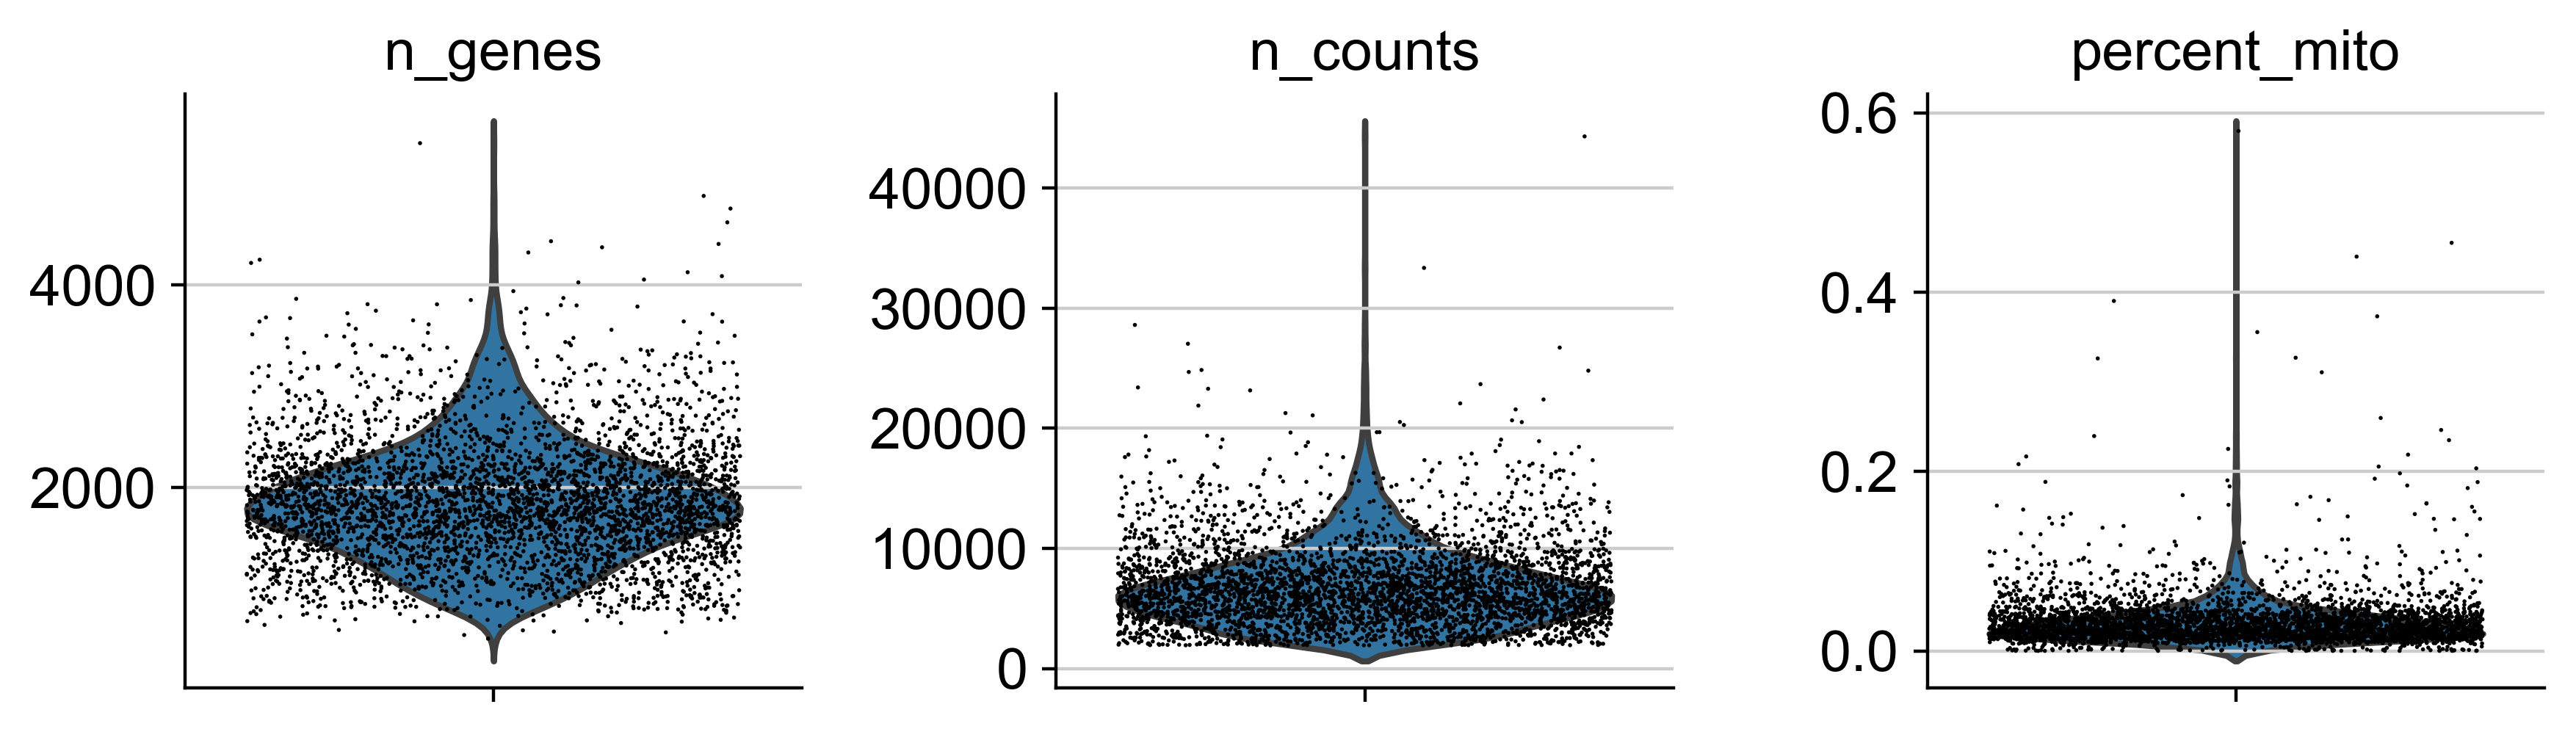

In [26]:
sc.pl.violin(ind4, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel = True)

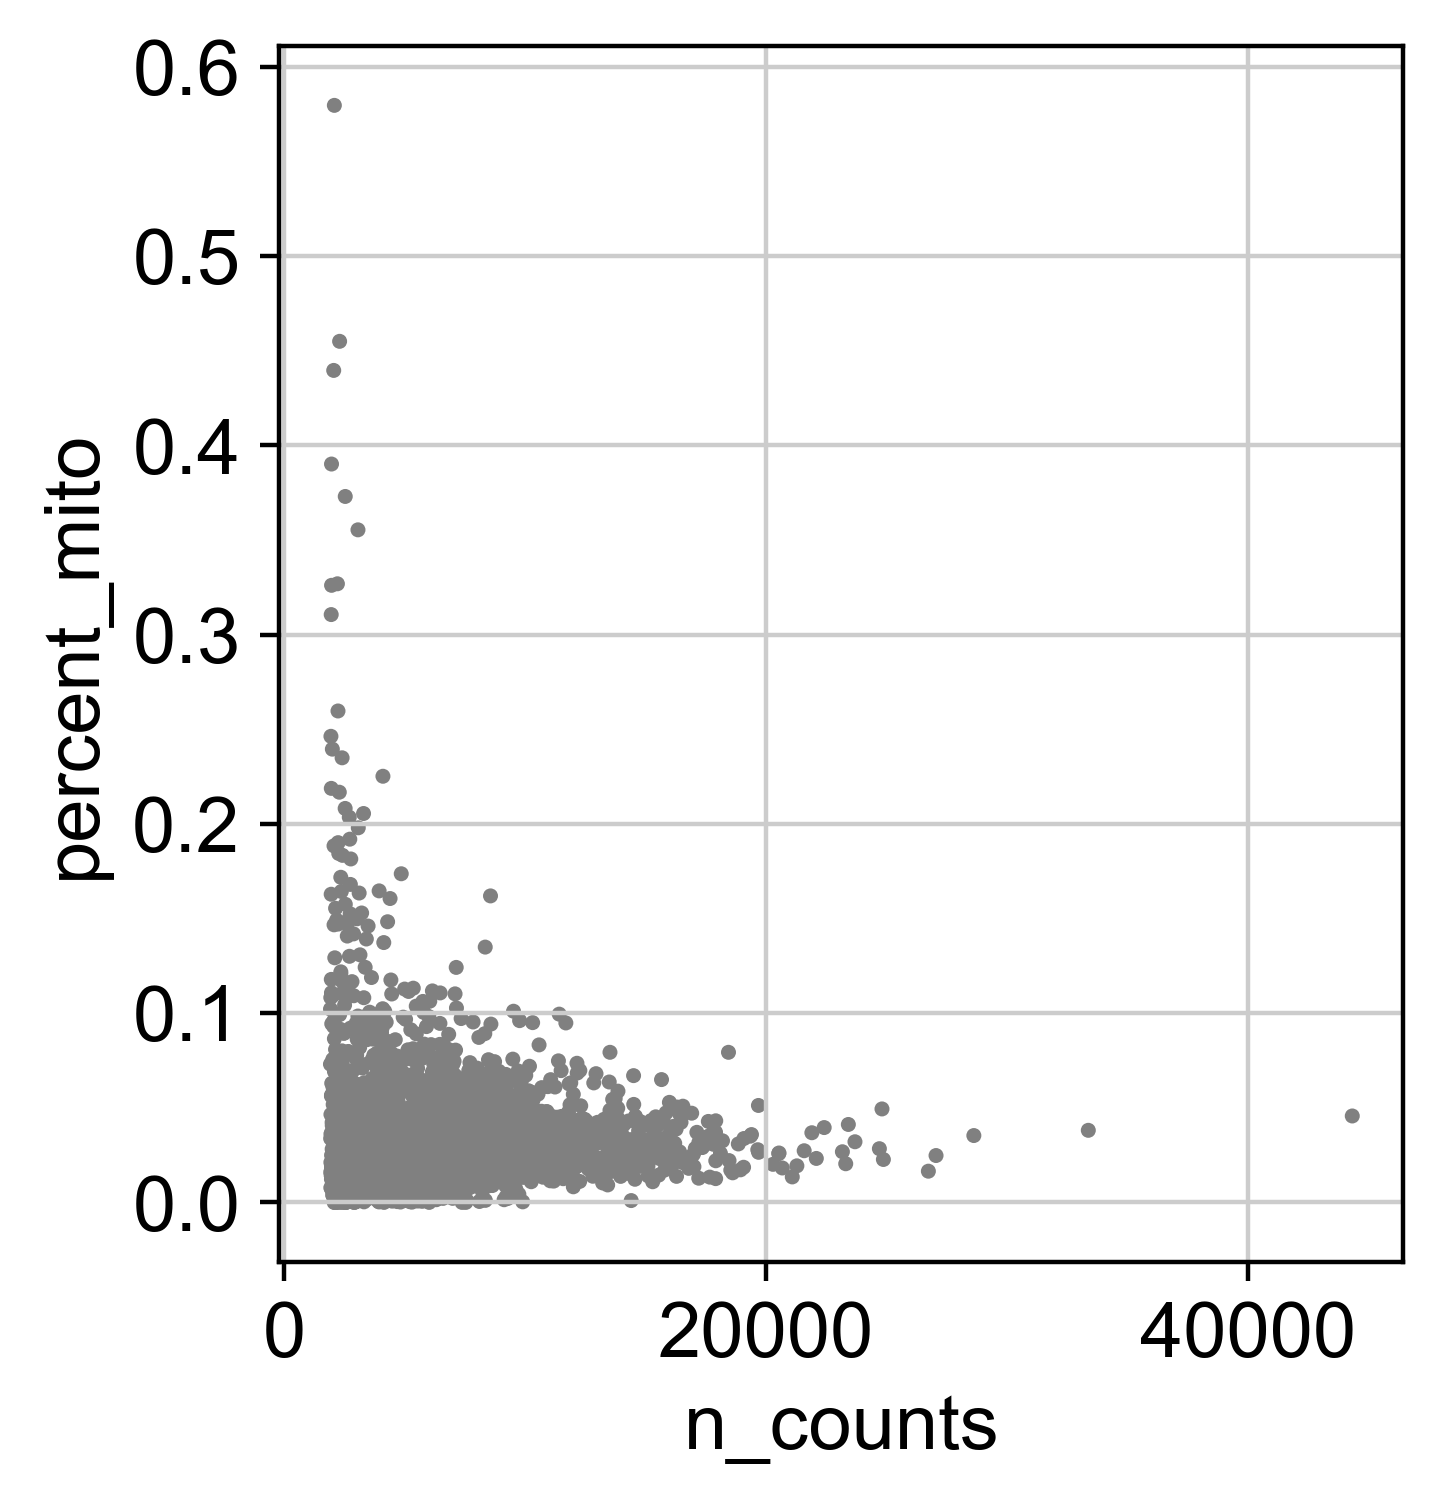

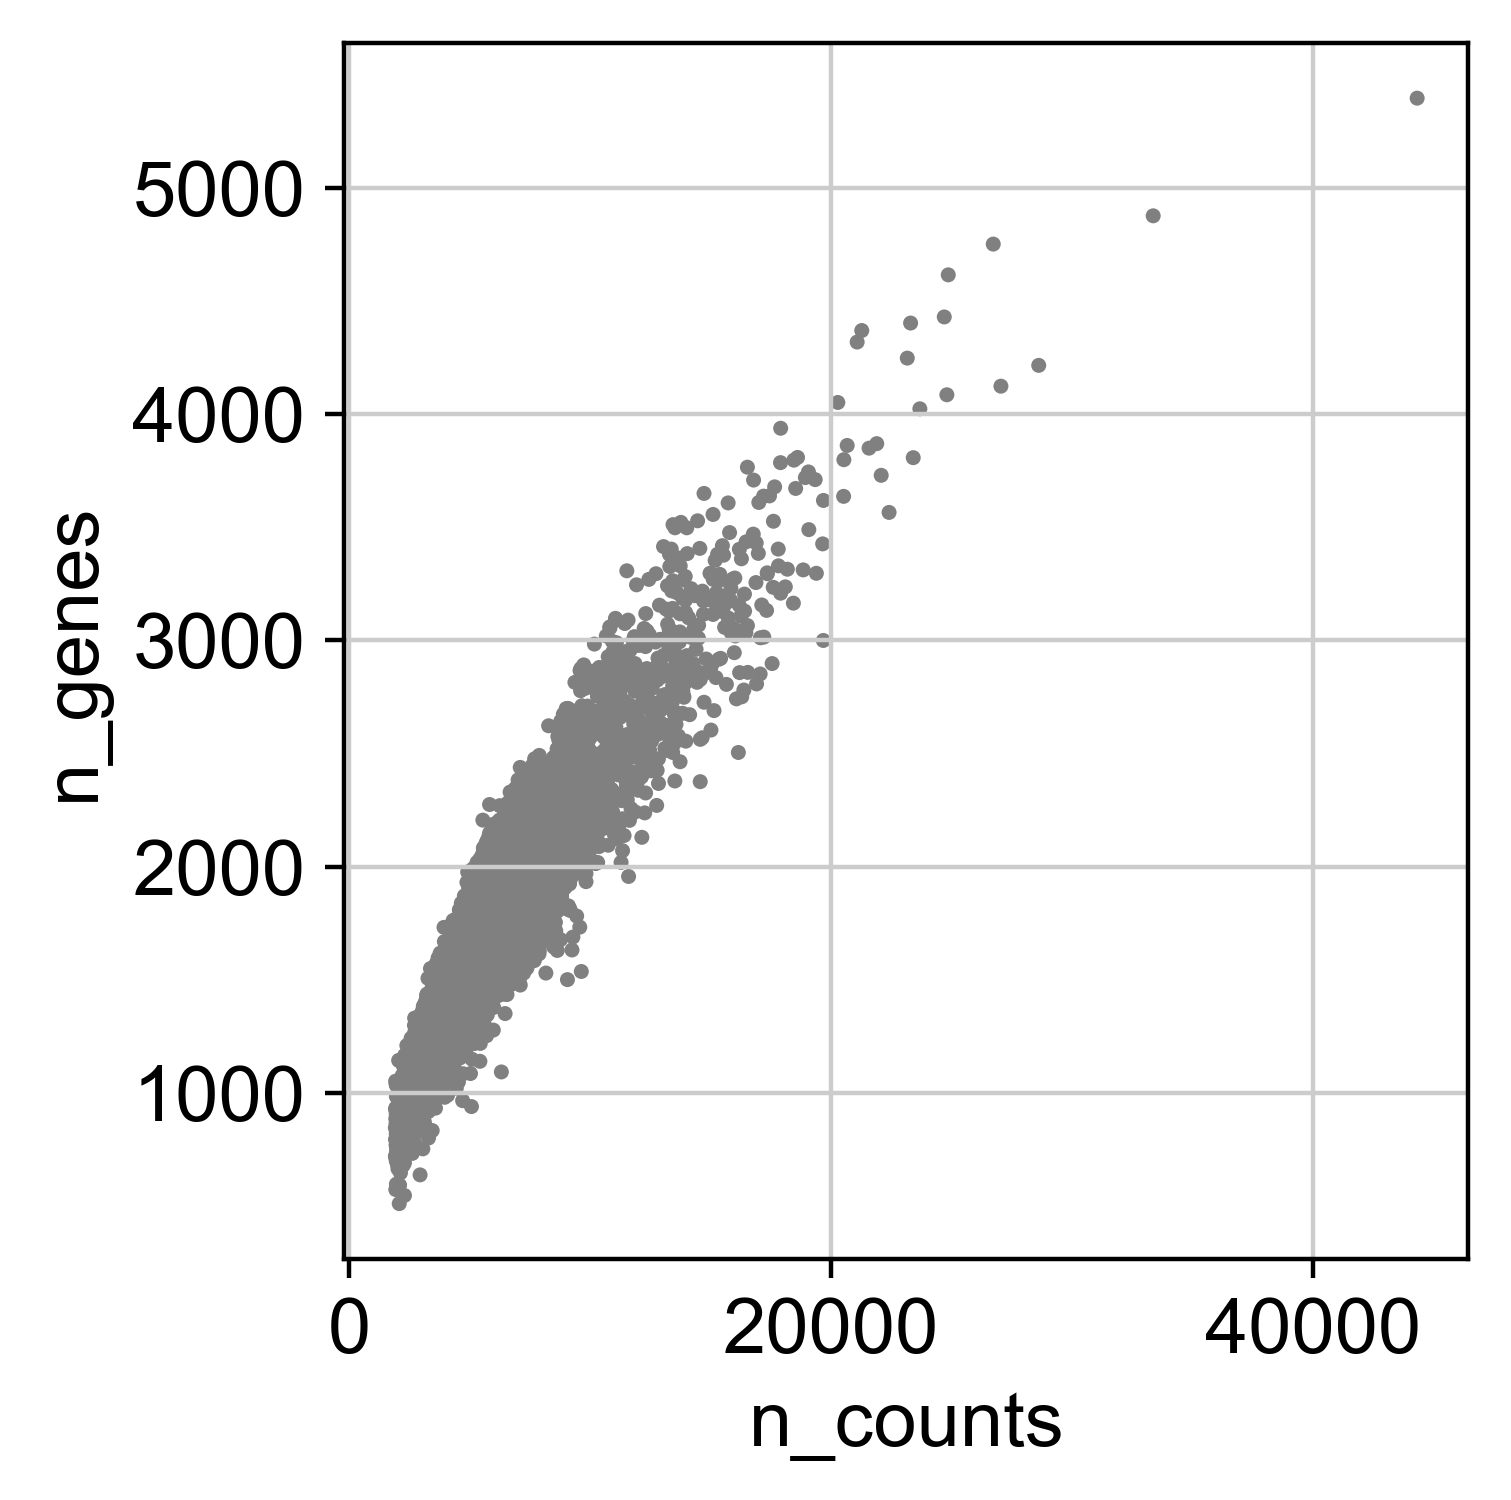

In [28]:
sc.pl.scatter(ind4, x='n_counts', y='percent_mito')
sc.pl.scatter(ind4, x='n_counts', y='n_genes')

In [29]:
#filter out cells that have too much percent mito
ind4 = ind4[ind4.obs['n_genes']<5000,:]
ind4 = ind4[ind4.obs['percent_mito']<0.08,:]

In [30]:
#log transform raw data:
ind4.raw = sc.pp.log1p(ind4, copy=True)

#normalize per cell
sc.pp.normalize_per_cell(ind4, counts_per_cell_after=1e4)

In [31]:
#identify highly variable genes:
ind4_filter_result = sc.pp.filter_genes_dispersion(ind4.X, min_mean = 0.0125, min_disp=0.5)

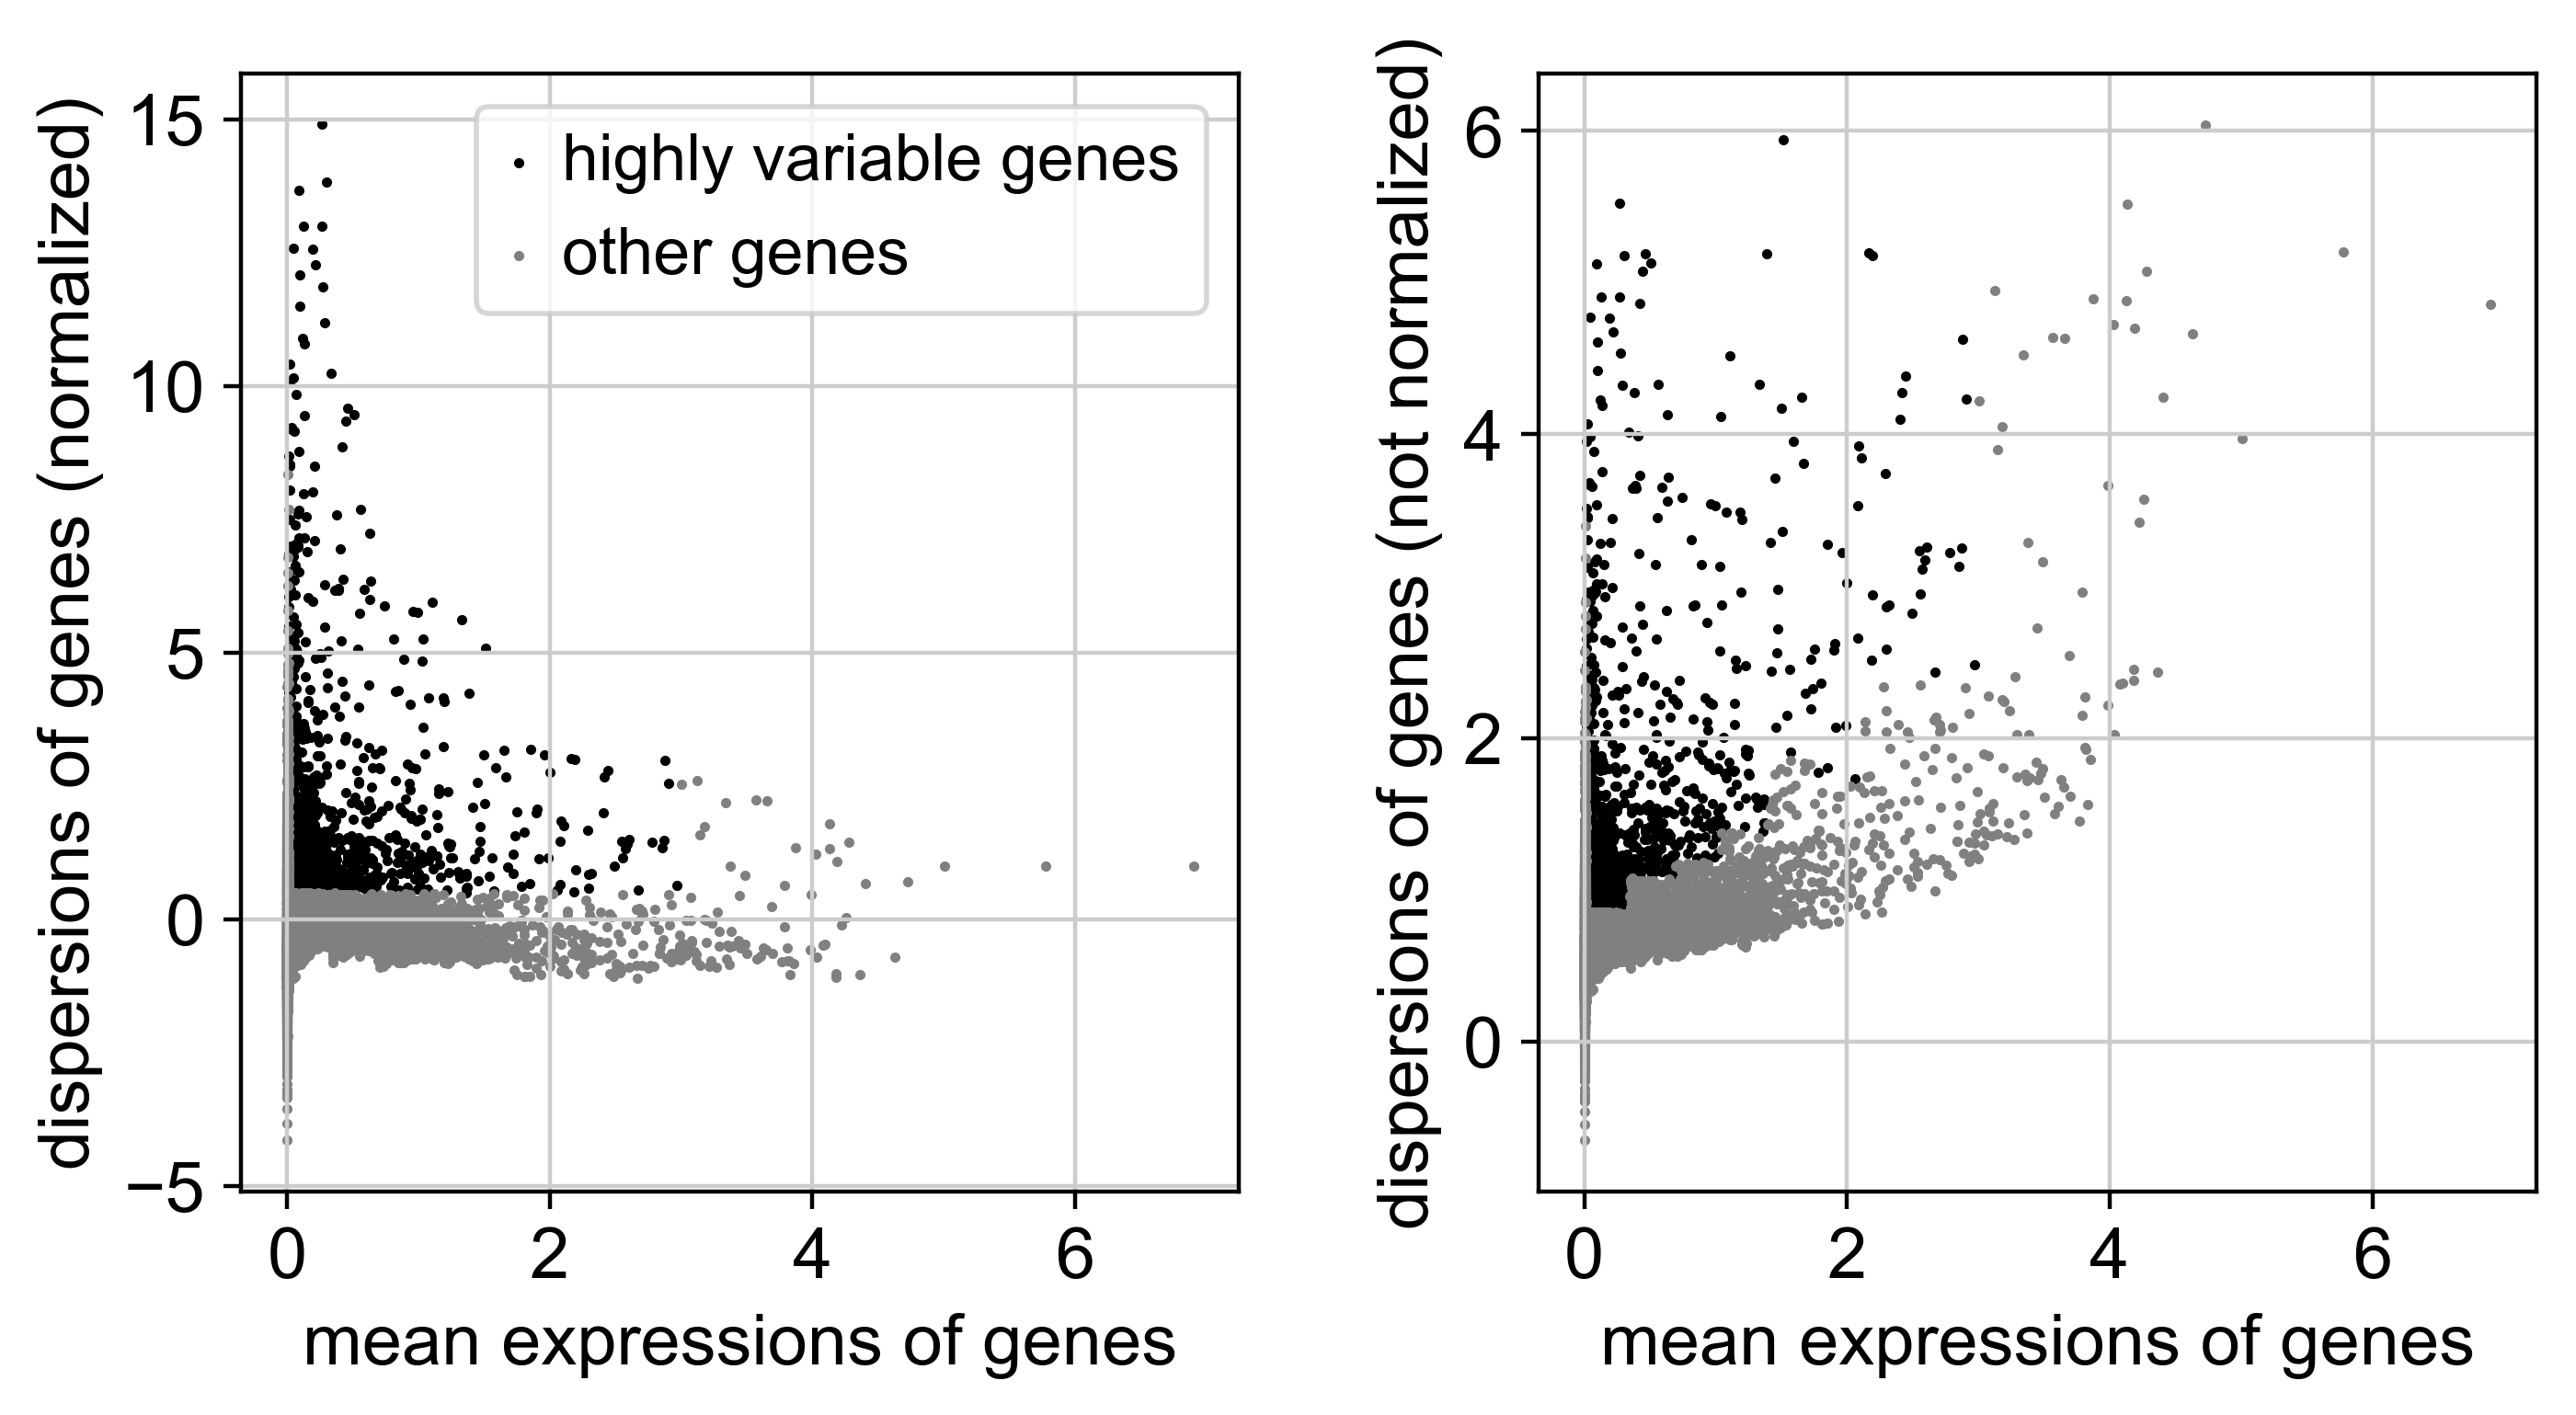

In [32]:
sc.pl.filter_genes_dispersion(ind4_filter_result)

In [33]:
#filter based on highly variable genes:
ind4 = ind4[:, ind4_filter_result.gene_subset]

#log transform again for some reason
sc.pp.log1p(ind4)

#regress out 
sc.pp.regress_out(ind4, ['n_counts', 'percent_mito'])
sc.pp.scale(ind4, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:09.53)


In [34]:
ind4.write(results_file)

In [35]:
#compute PCA:
sc.tl.pca(ind4, svd_solver='arpack')

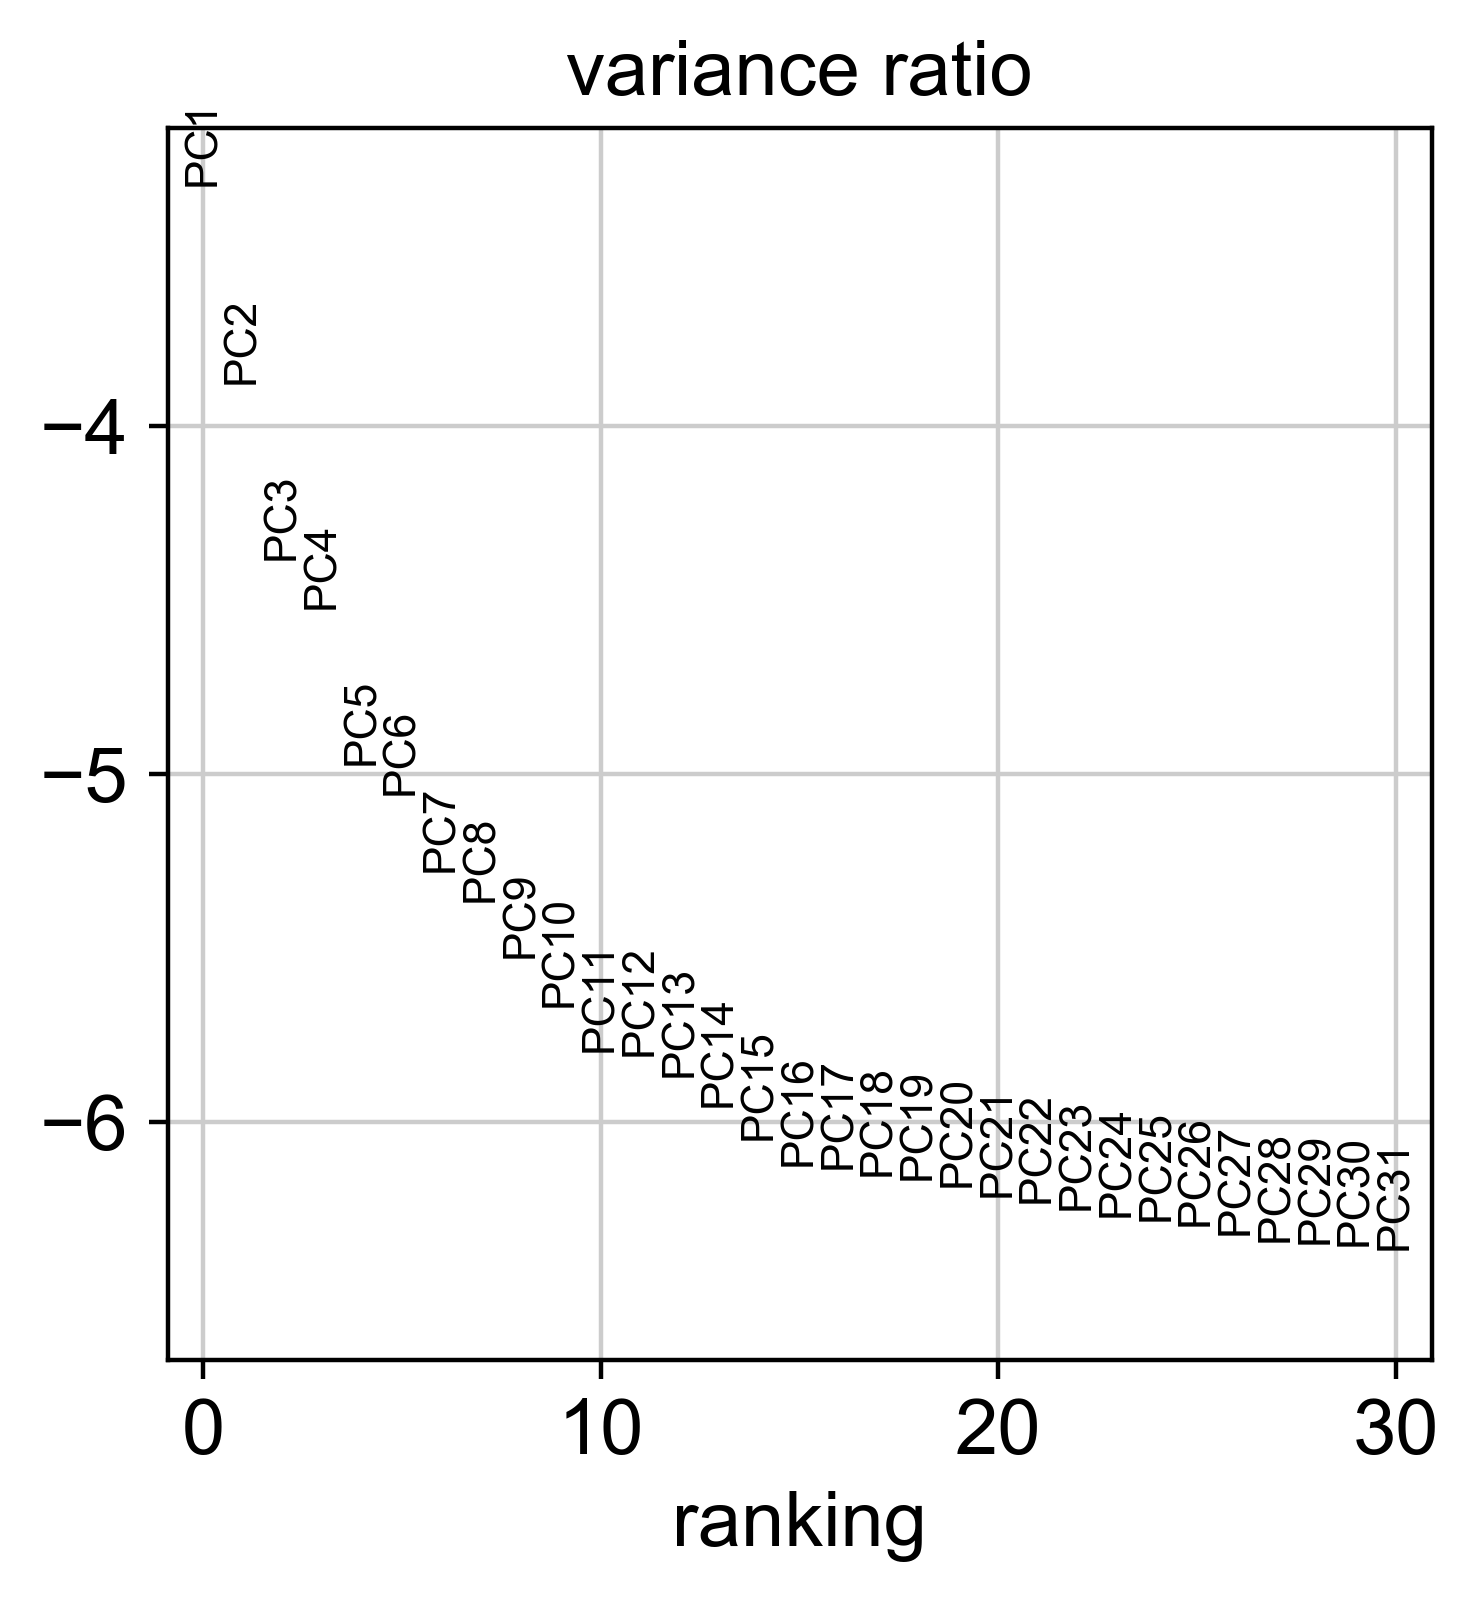

In [38]:
sc.pl.pca_variance_ratio(ind4, log=True)

In [39]:
sc.pp.neighbors(ind4, n_neighbors=10, n_pcs=40);

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:07.50) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [55]:
#add doublet score and predicted doublets to ind4.obs:
ind4_doublet_scores, ind4_predicted_doublets = [], []
for i, barcode in enumerate(barcodes):
    if barcode in ind4.obs.index:
        ind4_doublet_scores.append(doublet_scores[i])
        if predicted_doublets[i] == False:
            ind4_predicted_doublets.append(0)
        else:
            ind4_predicted_doublets.append(1)
ind4.obs['predicted_doublets'] = np.array(ind4_predicted_doublets)
ind4.obs['doublet_score'] = np.array(ind4_doublet_scores)

In [56]:
#add cell type identity
ind4_cell_identities = [[line.split()[0][5:] + "-1", line.split()[1]] for line in open("/Users/samuelmorabito/Documents/kessenbrock_rotation/RNA_velocity/10xdataforrnavelocity/ind4_celltypes.tsv", 'r')]

ind4_celltypes = []
for i, info in enumerate(ind4_cell_identities):
    if info[0] in ind4.obs.index:
        ind4_celltypes.append(info[1])
ind4.obs['cell_ids'] = np.array(ind4_celltypes)

In [69]:
sc.tl.tsne(ind4)
sc.tl.umap(ind4)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:43.98) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing UMAP
    finished (0:00:07.29) --> added
    'X_umap', UMAP coordinates (adata.obsm)


saving figure to file ./figures/tsneind4_doublet_tsne.pdf


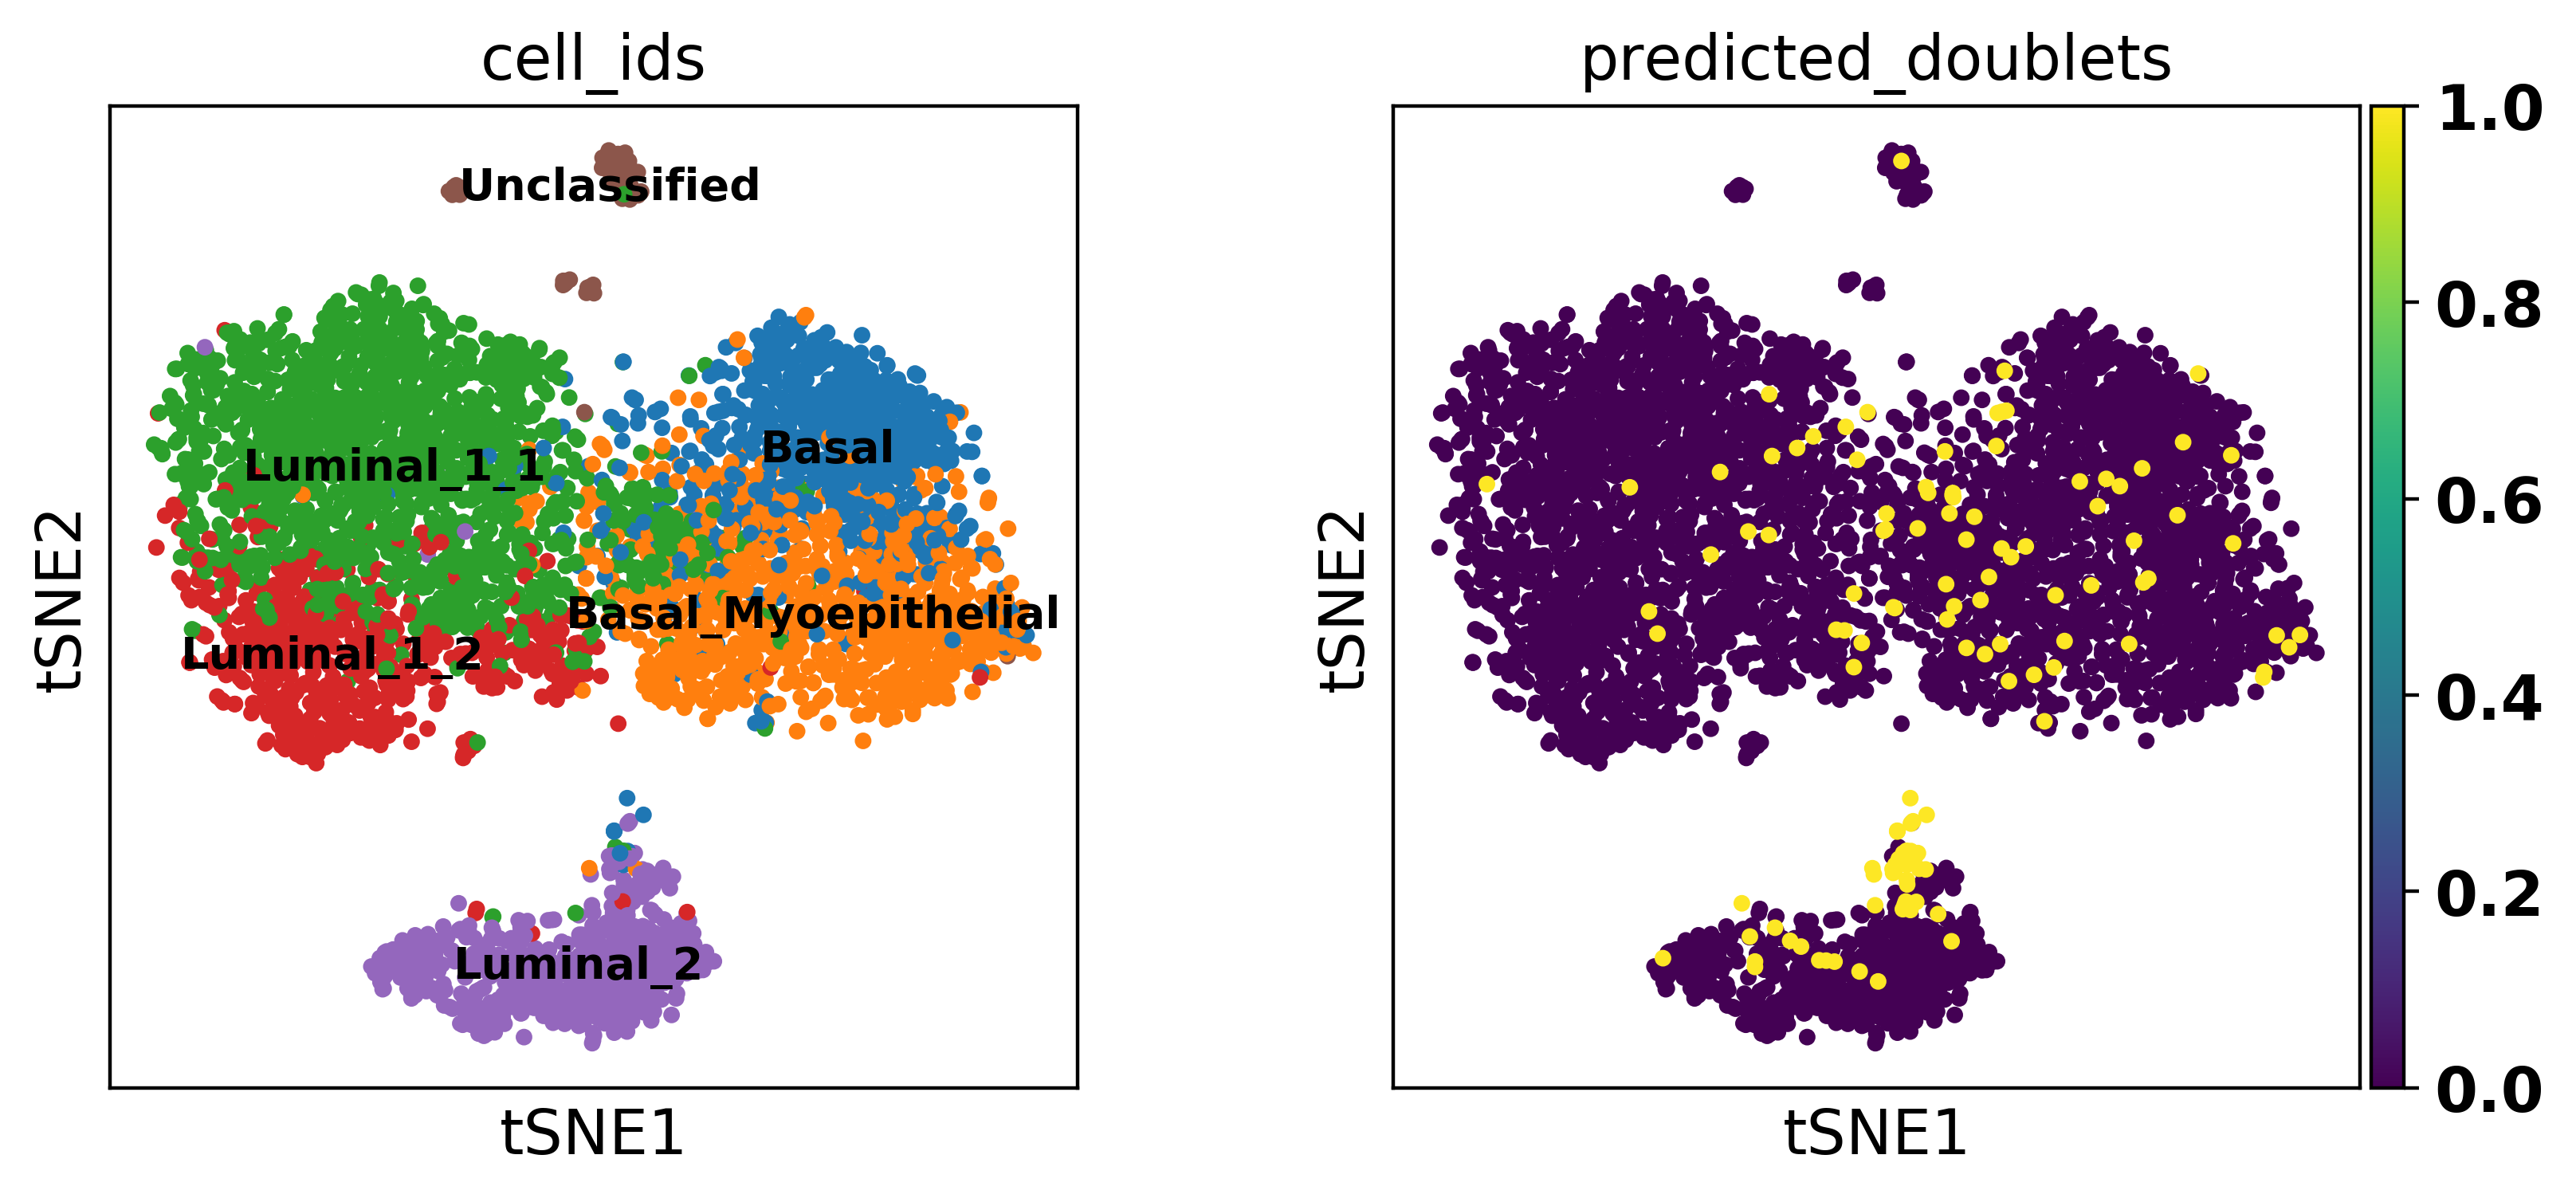

In [113]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

sc.pl.tsne(ind4, color=['cell_ids', 'predicted_doublets'], legend_loc="on data", save="ind4_doublet_tsne.pdf")

In [111]:
? sc.pl.tsne()

In [110]:
#ind4_no_doublets = ind4[:, ]
ind4.o

array([False, False, False, ..., False, False, False])